In [1]:
#preprocessing SANBS data

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

df=pd.read_csv("../1_data/private/SANBSdata.csv")
len(df)

5115926

In [2]:
#merge with don hist

df['Visit_Date']=pd.to_datetime(df['Visit_Date']).dt.strftime('%Y-%m-%dT%H:%M:%SZ') #covert to ISO -#2019-03-26T00:00:00Z\n",
don_hist=pd.read_csv("../1_data/private/don_hist2.csv")

df=pd.merge(df, don_hist[['DonorID', 'Visit_Date','rbc_loss_last_12_months', 'rbc_loss_last_24_months']], how='left', on=["DonorID", "Visit_Date"])



In [4]:
#drop theraputic donations

df.drop(df[(df['Outcome'] == 'THERAPEUTIC')].index, inplace=True)

#add a column OUTCOME_TYPE that indicates hgb deferal, other deferral or completed donation to indicate deferral type

df.loc[ (df['Outcome'] == 'DEFERRAL') &(df["category"]=='Haematocrit/Haemoglobin'), 'OUTCOME_TYPE'] = 'low hgb'
df.loc[(df['Outcome'] == "SUCCESSFUL DONATION"), 'OUTCOME_TYPE'] = 'completed'
df.loc[(df['Outcome'] == "DEFERRAL") & (df["category"]!='Haematocrit/Haemoglobin') , 'OUTCOME_TYPE'] = 'other deferral'
df['OUTCOME_TYPE'].fillna("no draw", inplace=True)

df.drop(df[df['Visit_Date'].isna()].index, inplace=True) #remove any missing visit dates

df["Visit_Date"] = df["Visit_Date"].astype("datetime64") #convert to date time object

df.sort_values(by=['DonorID', 'don_Sequence', 'Visit_Date'], axis = 0, inplace=True)


In [5]:

#add censored column (indicates whether row is right censored) 0-censored, 1-notcensored
df['CENSORED']=np.where(df['DonorID'] == df['DonorID'].shift(-1), 1, 0)

#add time_to_return column (time between visits)
#if return exists -> difference between visit dates
#else difference between visit date and end of data collection 2022-12-31

df['time_to_return']= np.where(df['CENSORED']==1, (df['Visit_Date'].shift(-1)-df['Visit_Date'])/np.timedelta64(1, 'D'), (dt.datetime(2022, 12, 31) - df["Visit_Date"])/np.timedelta64(1, 'D'))


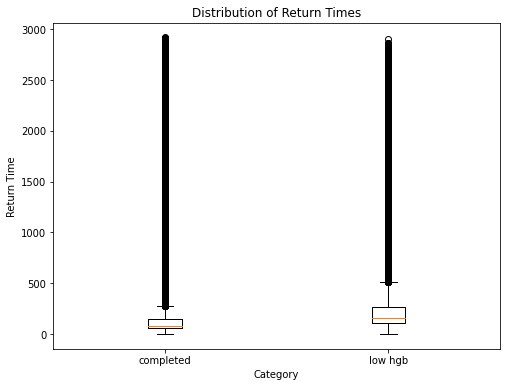

0


In [6]:

# Create a boxplot to see dictribution of retunr time before subtracting ineligible period
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['OUTCOME_TYPE'] == 'completed']['time_to_return'],
             df[df['OUTCOME_TYPE'] == 'low hgb']['time_to_return']],
            labels=['completed', 'low hgb'])

plt.xlabel('Category')
plt.ylabel('Return Time')
plt.title('Distribution of Return Times')
plt.show()

df_end=df.loc[df['time_to_return'] <0]
print(len(df_end))


In [7]:
#remove outcomes with def_end < visit_date
df.drop(df[df['Visit_Date'] > df['Def_end']].index, inplace=True)


In [8]:
#remove permanent deferrals
df.drop(df[df.Deferral_permanent == 'Perm'].index, inplace=True)
df.drop(df[(df['OUTCOME_TYPE'] == 'other deferral') & (df['Deferral_permanent'] == 'NoDeferral')].index, inplace=True)



In [9]:
#compute time_to_return with shifts for completed donation: subtract 56 days 
df['time_to_return2']=df['time_to_return']

df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'completed', (df['time_to_return2'] - 56) , df['time_to_return'])

#end of data collection
#df['time_to_return']=np.where((df['time_to_return'] < 0)& (df.OUTCOME_TYPE=='completed') , df['time_to_return2'], df['time_to_return'])

#compute time_to_return with shifts for other donations
#first covert eligibilty year and month to a datetime object

df["Def_end"] = df["Def_end"].astype("datetime64")
df['def_Year'] = df['Def_end'].dt.year  
#df['Def_end'].isna().sum()

#hgb deferrals
df['time_to_return'] = np.where((df['OUTCOME_TYPE'] == 'low hgb') & (df['def_Year']< 2023) , (df['time_to_return2'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])

#other deferrals
df['time_to_return'] = np.where((df['OUTCOME_TYPE'] == 'other deferral') & (df['def_Year'] < 2023), (df['time_to_return2'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])
df['time_to_return'].isna().sum()

#drop individuals who returned before end of eligibility period
df.drop(df[(df.time_to_return<0)].index, inplace =True)


In [10]:
# add variable first time -> 1- first time, 0-repeat

df['first_time'] = np.where((df['don_Sequence'] == 1.0) & (df['don_Sequence'].shift(1)!=1.0) & (df['DonorID'] != df['DonorID'].shift(1)), 1, 0)

# make age categorical - high school age
df['high_school_age']=np.where(df['Visit_Age']<=20, 1, 0)

#add donor history
df['cum_lifetime_donations']=df['don_Sequence']


In [11]:
#Fixed-Mobile Donations Analysis

#plot number - mobile=0, fixed=1
fixed=df["Fixed"]
#sns.histplot(df, x="Fixed", stat="probability")
#sns.countplot(fixed)
#print(fixed.value_counts())

# group and remove some categories that are not fixed or mobile
# administrative site and apheresis clinic fall under fixed
# exclude others

df.drop(df[(df['Fixed']== 'Lapsed Clinic') | (df['Fixed']=='Processing Lab')| (df['Fixed']=='Unallocated') 
           | (df["Fixed"]== 'Laboratorium') |(df["Fixed"]=='Doctor')].index, inplace=True)

df['Fixed_mobile'] = np.where(df['Fixed'] == 'Mobile Clinic', 0, 1) #mobile is 0, fixed is 1


#create a column to indicate 
    #1. mobile then mobile - mm
    #2. mobile then fixed -mf
    #3. fixed then fixed - ff
    #4. fixed then mobile - fm

df["FIXED_NEXT"] = np.where(df['DonorID'] == df['DonorID'].shift(-1), df['Fixed_mobile'].shift(-1), 10)
df.loc[((df['FIXED_NEXT']== 1) & (df['Fixed_mobile']== 1)), 'fixed_mobile_pattern'] = 'FF'

df.loc[((df['FIXED_NEXT']==0) & (df['Fixed_mobile']== 0)), 'fixed_mobile_pattern']= 'MM'

df.loc[((df['FIXED_NEXT']==0) & (df['Fixed_mobile']== 1)), 'fixed_mobile_pattern'] = 'FM'

df.loc[((df['FIXED_NEXT']==1) & (df['Fixed_mobile']== 0)), 'fixed_mobile_pattern']= 'MF'
df['fixed_mobile_pattern'].fillna('last', inplace=True)



In [12]:
# create a events column to generate cause specific Cumulative incidence functions
# competing events are - return to mobile, return to fixed

df['competing_events'] = np.where((df['fixed_mobile_pattern']=="MF")|(df['fixed_mobile_pattern']=="FF"), 1, 2)
df['competing_events'] = np.where((df['fixed_mobile_pattern']=="last"), 0, df['competing_events'])

In [14]:
df.loc[(df['donation_product'] == 'WB')|
           (df['donation_product'] == 'WBSB')| (df['donation_product'] == 'WBMED')| (df['donation_product'] == 'WBDISC')
           |( df['donation_product'] == 'WBOB') |(df['donation_product'] == 'WBDP') | (df['donation_product'] == 'WBD') ,
           'donation_product']='WB'




In [15]:
#recode ABO_RH
df.loc[df['ABO_RH'] == 'A2BPOS', 'ABO_RH'] = 'ABpos'
df.loc[df['ABO_RH'] == 'A2NEG', 'ABO_RH'] = 'Aneg'
df.loc[df['ABO_RH'] == 'A2POS', 'ABO_RH'] = 'Apos'
df.loc[df['ABO_RH'] == 'ANEGL', 'ABO_RH'] = 'Aneg'
df.loc[df['ABO_RH'] == 'BwPOS', 'ABO_RH'] = 'Bpos'
df.loc[df['ABO_RH'] == 'ONEGH', 'ABO_RH'] = 'Oneg'
df.loc[df['ABO_RH'] == 'OPOSH', 'ABO_RH'] = 'Opos'
df.loc[df['ABO_RH'] == 'OPOSL', 'ABO_RH'] = 'Opos'
df.loc[df['ABO_RH'] == 'wABNEG', 'ABO_RH'] = 'ABneg'
df.loc[df['ABO_RH'] == 'wABPOS', 'ABO_RH'] = 'ABpos'
df.loc[df['ABO_RH'] == 'wANEG', 'ABO_RH'] = 'Aneg'
df.loc[df['ABO_RH'] == 'wAPOS', 'ABO_RH'] = 'Apos'
df.loc[df['ABO_RH'] == 'APOS', 'ABO_RH'] = 'Apos'
df.loc[df['ABO_RH'] == 'ANEG', 'ABO_RH'] = 'Aneg'
df.loc[df['ABO_RH'] == 'BPOS', 'ABO_RH'] = 'Bpos'
df.loc[df['ABO_RH'] == 'BNEG', 'ABO_RH'] = 'Bneg'
df.loc[df['ABO_RH'] == 'ABPOS', 'ABO_RH'] = 'ABpos'
df.loc[df['ABO_RH'] == 'ABNEG', 'ABO_RH'] = 'ABneg'
df.loc[df['ABO_RH'] == 'OPOS', 'ABO_RH'] = 'Opos'
df.loc[df['ABO_RH'] == 'ONEG', 'ABO_RH'] = 'Oneg'


df.ABO_RH.value_counts()



Opos     2246503
Apos     1224213
Bpos      720240
Oneg      283142
ABpos     173497
Aneg      139771
Bneg       63377
ABneg      17275
UNK         1256
Name: ABO_RH, dtype: int64

In [16]:
df.race.value_counts()

White            2468287
African Black    1759599
Asian             328759
Mixed Race        268633
unknown            44056
Name: race, dtype: int64

In [17]:
# Compute donation product for deferred donors - using the following criteria
 # 1) if donor only has WB then deferred donation is WB
 # 2) if next donation procedure is WB then deferred donation is WB/
 # 3) if previous donation procedure is WB then deferred donation is WB/
 # 4) if only donated one time and got deferred - WB
 
#prev successful 
#next successful
df.sort_values(by=['DonorID', 'don_Sequence', 'Visit_Date'], axis = 0, inplace=True)

df["NEXT_DON"] = np.where(df['DonorID'] == df['DonorID'].shift(-1), df['donation_product'].shift(-1), 10)
df["PREV_DON"] = np.where(df['DonorID'] == df['DonorID'].shift(1), df['donation_product'].shift(1), 10)



In [18]:

df['def_prod_imputed'] = np.where((df['donation_product'] == 'DEF PROD') & (df.PREV_DON=='WB'), 1, 0)
df['def_prod_imputed'] = np.where((df['donation_product'] == 'DEF PROD') & (df.NEXT_DON=='WB'), 1, df.def_prod_imputed)
df['def_prod_imputed'] = np.where((df['donation_product'] == 'DEF PROD') & ((df.NEXT_DON==10) & (df.PREV_DON==10)), 1, df.def_prod_imputed)
df['donation_product']=np.where(df.def_prod_imputed == 1, 'WB', df.donation_product)


In [19]:
# backward fill remaining NOT DRAWNs- most proximal next visit
df['donation_product']=np.where((df['donation_product'] == 'DEF PROD'), np.NaN, (df['donation_product']))

df['donation_product'] = df.groupby('DonorID')['donation_product'].bfill()


In [20]:
#keep on wb and rbc
df.drop(df[(df['donation_product'] != 'WB')].index, inplace=True)


#keep only data after 2017
mask = (df['Visit_yr'] >= 2017) 
df = df.loc[mask]



In [21]:
#check if donor return to the same mobile ID

#for fixed only, for mobile only and overall

df.loc[(df.Fixed_mobile==0) & (df['MobileID'] == df['MobileID'].shift(-1)), 'return_to_same_ID_by_dn']= 'mm' #for mobile only
df.loc[(df.Fixed_mobile==1) & (df['MobileID'] == df['MobileID'].shift(-1)), 'return_to_same_ID_by_dn']= 'ff' #for fixed only
df.loc[(df['MobileID'] == df['MobileID'].shift(-1)), 'return_to_same_ID']= 1 #overall


In [22]:
# add oppurtunities to donate in next 12 months - computed in 00_mobileID.ipynb and saved in csv file, mID_table
df_mID=pd.read_csv("../1_data/private/mID_table.csv")
df_mID["Visit_Date"] = df_mID["Visit_Date"].astype("datetime64") #convert to date time object
df=pd.merge(df, df_mID[['MobileID', 'Visit_Date', 'count_in_next_12_months']], how='left', on=["MobileID", "Visit_Date"])


In [23]:
df.loc[df.count_in_next_12_months==1, 'Opp_to_donate']="Annual_1"
df.loc[df.count_in_next_12_months==2, 'Opp_to_donate']="Bi_Annual_2"
df.loc[(df.count_in_next_12_months>=3) & (df.count_in_next_12_months<=6), 'Opp_to_donate']="3_6"
df.loc[(df.count_in_next_12_months>6) & (df.count_in_next_12_months<=12), 'Opp_to_donate']="7_12"
df.loc[(df.count_in_next_12_months>12), 'Opp_to_donate']="12_more"
df.Opp_to_donate.value_counts()

12_more        748927
3_6            739486
7_12           248341
Bi_Annual_2    172711
Annual_1       161850
Name: Opp_to_donate, dtype: int64

In [45]:
df = df.sort_values(by=['DonorID', 'Visit_Date'])
df['TimeSinceFirstDonation'] = df.groupby('DonorID')['Visit_Date'].diff().dt.days

In [47]:
# Identify the first-time donors who received a hemoglobin deferral #within a year
first_time_comp = df.loc[(df['first_time']==1)]
#  keep only the first-time donors and their subsequent donations
filtered_df = df.loc[df['DonorID'].isin(first_time_comp['DonorID'])]
filtered_df = filtered_df[filtered_df['TimeSinceFirstDonation'] <= 365]
grouped_filtered_df=filtered_df.groupby('DonorID')["OUTCOME_TYPE"].apply(list)
grouped_filtered_df= pd.DataFrame({'DonorID': grouped_filtered_df.index, 'Outcomes': grouped_filtered_df.values})
grouped_filtered_df['Outcomes'] = grouped_filtered_df['Outcomes'].apply(tuple)
# Split the list column into multiple columns
grouped_filtered_df= grouped_filtered_df['Outcomes'].apply(pd.Series)


In [54]:
group_df2=grouped_filtered_df

comp=group_df2.loc[group_df2[0]=='completed']
hgb=group_df2.loc[group_df2[0]=='low hgb']

#look at consectutive
comp2=comp.loc[comp[1]=='completed']
hgb2=hgb.loc[hgb[1]=='low hgb']
comp_hgb=comp.loc[comp[1]=='low hgb']

##calculate probabulity of first tiem donors returning after 2 comp donation
num=comp2[2].notna().sum()
prob_f_cc=num/len(comp2)
print(prob_f_cc)

#calculate probabulity of first time donors returning after 2 hgb def
num=hgb2[2].notna().sum()
prob_f_hh=num/len(hgb2)
print(prob_f_hh)

#calculate probabulity of first tim donors returning after a comp donation then a hgb deferral
num=comp_hgb[2].notna().sum()
prob_f_ch=num/len(comp_hgb)
print(prob_f_ch)

0.8010049238751275
0.6385767790262172
0.6916457511652923


In [27]:
#compute deferral rates

first=df.query("first_time == 1")
repeat=df.query("first_time == 0")
    
table={}
table['-']=['Female', 'Male', 'All']
   
    #first time
female=(len(first.loc[(first.sex == 'F') & (first.OUTCOME_TYPE=='low hgb')])/len(first.loc[(first.sex == 'F')]))
male=(len(first.loc[(first.sex == 'M') & (first.OUTCOME_TYPE=='low hgb')])/len(first.loc[(first.sex == 'M')]))
alls=(len(first.loc[(first.OUTCOME_TYPE=='low hgb')])/len(first))
table['First Time']=[female, male, alls]
    
    #repeat
    
female=(len(repeat.loc[(repeat.sex == 'F') & (repeat.OUTCOME_TYPE=='low hgb')])/len(repeat.loc[(repeat.sex == 'F')]))
male=(len(repeat.loc[(repeat.sex == 'M') & (repeat.OUTCOME_TYPE=='low hgb')])/len(repeat.loc[(repeat.sex == 'M')]))
alls=(len(repeat.loc[(repeat.OUTCOME_TYPE=='low hgb')])/len(repeat))
table['Repeat']=[female, male, alls]
    
    #all 
    
female=(len(df.loc[(df.sex == 'F') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.sex== 'F')]))
male=(len(df.loc[(df.sex == 'M') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.sex == 'M')]))
alls=(len(df.loc[(df.OUTCOME_TYPE=='low hgb')])/len(df))
table['All']=[female, male, alls]


In [28]:
#compute stats to report
print("-----------total deferrals------------")
print(df.OUTCOME_TYPE.value_counts())  # number of deferrals
print(len(df))#total observations

print('-----------total counts of outcomes---------')
print(df['OUTCOME_TYPE'].value_counts())

print("-----------deferral rate by fixed mobile---------")

print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 1))])/len(df.loc[(df['Fixed_mobile']==1)]))
print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 0))])/len(df.loc[(df['Fixed_mobile']==0)]))

print('------------% of fixed/mobile--------------')
print(len(df.loc[(df['Fixed_mobile']==1)])/len(df))
print(len(df.loc[(df['Fixed_mobile']==0)])/len(df))

print('--------------deferral rate table by sex -----------')
table=pd.DataFrame.from_dict(table)
print(table)

print('--------donor loyalty to mobileID--------------')
print(len(df.loc[df.return_to_same_ID_by_dn =='mm'])/len(df.loc[(df.Fixed_mobile==0)])) #mob only
print(len(df.loc[df.return_to_same_ID_by_dn =='ff'])/len(df.loc[(df.Fixed_mobile==1)]))#fixed only
print(len(df.loc[df.return_to_same_ID ==1])/len(df))#overall


print('---------total donors---------------')
print(df.DonorID.nunique())
print('---------total visits---------------')
print(len(df))


-----------total deferrals------------
completed         3529609
other deferral     225968
low hgb            196882
no draw             66433
Name: OUTCOME_TYPE, dtype: int64
4018892
-----------total counts of outcomes---------
completed         3529609
other deferral     225968
low hgb            196882
no draw             66433
Name: OUTCOME_TYPE, dtype: int64
-----------deferral rate by fixed mobile---------
0.04154421821769256
0.055154253233490935
------------% of fixed/mobile--------------
0.45298405630208527
0.5470159436979147
--------------deferral rate table by sex -----------
        -  First Time    Repeat       All
0  Female    0.004685  0.082618  0.078366
1    Male    0.000450  0.022485  0.021663
2     All    0.002890  0.051193  0.048989
--------donor loyalty to mobileID--------------
0.5914215715261749
0.7376783444493638
0.657673557786574
---------total donors---------------
587218
---------total visits---------------
4018892


In [668]:
#drop cols that arent needed 

#save preprocessed file
df.to_csv(("../1_data/private/preprocessed_data.csv"), index=False)


In [26]:
"""
# Create a boxplot to see distribution of return times after subtrating ineligiblity period
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['OUTCOME_TYPE'] == 'completed']['time_to_return'],
             df[df['OUTCOME_TYPE'] == 'low hgb']['time_to_return']],
            labels=['completed', 'low hgb'])

plt.xlabel('Category')
plt.ylabel('Return Time')
plt.title('Distribution of Return Times')
plt.show()


df_end=df.loc[df['time_to_return'] <0]

print(len(df_end))

"""

"\n# Create a boxplot to see distribution of return times after subtrating ineligiblity period\nplt.figure(figsize=(8, 6))\nplt.boxplot([df[df['OUTCOME_TYPE'] == 'completed']['time_to_return'],\n             df[df['OUTCOME_TYPE'] == 'low hgb']['time_to_return']],\n            labels=['completed', 'low hgb'])\n\nplt.xlabel('Category')\nplt.ylabel('Return Time')\nplt.title('Distribution of Return Times')\nplt.show()\n\n\ndf_end=df.loc[df['time_to_return'] <0]\n\nprint(len(df_end))\n\n"

In [ ]:
"""
sns.histplot(df, x="Fixed_mobile", stat="probability")
#Plot fixed pattern
#create value count

df2 = df[df['fixed_mobile_pattern'] != 'last']
plt.figure()
g=sns.histplot(df2, x=df2["fixed_mobile_pattern"], stat="probability")
#plt.legend(title='Fixed-Mobile Pattern', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
plt.xlabel('Fixed-Mobile Pattern')
plt.show(g)


# the % of each fixed mobile pattern resulting in hemoglobin deferral or other deferral
plt.figure()
i=sns.histplot(data=df2, x="fixed_mobile_pattern", hue="OUTCOME_TYPE", stat = 'probability',binwidth=1, multiple="stack")
#plt.legend(title='Fixed vs Mobile by Year', loc='upper left', labels=['Mobile', 'Fixed'])
plt.show(i)

"""

In [ ]:

#calculate probabulity of first time donors returning after a comp donation
#num=comp[1].notna().sum()
#prob_f_c=num/len(comp)
#print(prob_f_c)

#calculate probabulity of first time donors returning after a hgb def
#num=hgb[1].notna().sum()
#prob_f_h=num/len(hgb)
#print(prob_f_h)